Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 2: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside your personal course repository for the course 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [2]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.special import softmax

## The *Nim* and *Nimply* classes

In [3]:
Nimply = namedtuple("Nimply", "row, num_objects")

In [4]:
class Nim:
    def __init__(self, num_rows: int, k: int = None, last_move: Nimply = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k
        self.last_move = last_move

    def __bool__(self):
        return bool(sum(self._rows) > 0)

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        self.last_move = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects

    def n_possible_moves(self) -> int:
        return sum(self._rows)

## Sample (and silly) startegies 

In [5]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)

In [6]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


In [7]:
import numpy as np


def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply


In [11]:
def expert_system(state: Nim) -> Nimply:
    """
    Details on https://en.wikipedia.org/wiki/Nim#Proof_of_the_winning_formula.
    """
    analysis = analize(state)
    rows_not_zero = len(state.rows) - state.rows.count(0)
    # case of one single row with lenght >= 2
    if state.rows.count(1) == (rows_not_zero - 1):
        row, num_objects = [(row, num_objects) for row, num_objects in enumerate(state.rows) if num_objects > 1][0]
        if (rows_not_zero % 2) == 1:
            num_objects = num_objects if (num_objects - 1) <= len(state.rows) else len(state.rows)
            return Nimply(row, num_objects - 1)
        else:
            num_objects = num_objects if num_objects <= len(state.rows) else len(state.rows)
            return Nimply(row, num_objects)
    # case with more row with length >= 2
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns == 0]
    if not spicy_moves:
        spicy_moves = [move for move in list(analysis["possible_moves"].keys())]
    ply = random.choice(spicy_moves)
    return ply

## Oversimplified match

In [22]:
logging.getLogger().setLevel(logging.INFO)

strategy = (expert_system, pure_random)

nim = Nim(6)
logging.info(f"init : {nim}")
player = 0
while nim:
    ply = strategy[player](nim)
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply)
    logging.info(f"status: {nim}")
    player = 1 - player
logging.info(f"status: Player {player} won!")

INFO:root:init : <1 3 5 7 9 11>
INFO:root:ply: player 0 plays Nimply(row=5, num_objects=2)
INFO:root:status: <1 3 5 7 9 9>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=3)
INFO:root:status: <1 3 5 4 9 9>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=3)
INFO:root:status: <1 0 5 4 9 9>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=1)
INFO:root:status: <1 0 5 3 9 9>
INFO:root:ply: player 0 plays Nimply(row=2, num_objects=3)
INFO:root:status: <1 0 2 3 9 9>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=2)
INFO:root:status: <1 0 0 3 9 9>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=2)
INFO:root:status: <1 0 0 1 9 9>
INFO:root:ply: player 1 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 0 0 1 9 9>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=1)
INFO:root:status: <0 0 0 0 9 9>
INFO:root:ply: player 1 plays Nimply(row=5, num_objects=4)
INFO:root:status: <0 0 0 0 9 5>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=4)

# Our Solution

In [8]:
NUM_MATCHES = 1000
NIM_SIZE = 5
N_GAMES_SIMULATED_PER_MOVE = 100

nim = Nim(NIM_SIZE)

## Methods

In [9]:
def generate_all_possible_moves(state: Nim) -> list:
    return [Nimply(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]

def max_num_objects(state: Nim) -> dict:
    return {r: c for r, c in enumerate(state.rows)}

def sample_random_move(state: Nim) -> Nimply:
    possible_moves = generate_all_possible_moves(state)
    move = random.choice(range(len(possible_moves)))
    return possible_moves[move], move

def sampler(state: Nim) -> Nimply:
    return sample_random_move(state=state)[0]

def generate_game(state: Nim) -> tuple:
    strategy = (sampler, pure_random)
    temp_state = deepcopy(state)
    first_move = None 
    player = 0 
    while temp_state:
        ply = strategy[player](temp_state)
        first_move = ply if first_move is None else first_move
        temp_state.nimming(ply)
        player = 1 - player
    return (first_move, player)

def generate_games(state: Nim, n: int = 1000) -> list:
    return [generate_game(state=state) for _ in range(n)]

def choose_best_move(state: Nim, n_games: int = 1000) -> Nimply:
    games = generate_games(state=state, n=n_games)
    winning_moves = np.array([game[0] for game in games if game[1] == 0])
    total_moves = np.array([game[0] for game in games])
    winning_moves, winning_count = np.unique(winning_moves, return_counts=True, axis=0)
    total_moves, total_count = np.unique(total_moves, return_counts=True, axis=0)

    best_move_val = -1 
    best_move_index = -1

    for i, move in enumerate(total_moves):
        for j, move2 in enumerate(winning_moves):
            if (move == move2).all():
                winrate = winning_count[j]/total_count[i]
                if winrate > best_move_val:
                    best_move_val = winrate
                    best_move_index = i
                break 
    
    best_move = total_moves[best_move_index]

    return Nimply(best_move[0], best_move[1])

def our_strategy(state: Nim) -> Nimply:
    return choose_best_move(state=state, n_games=N_GAMES_SIMULATED_PER_MOVE)

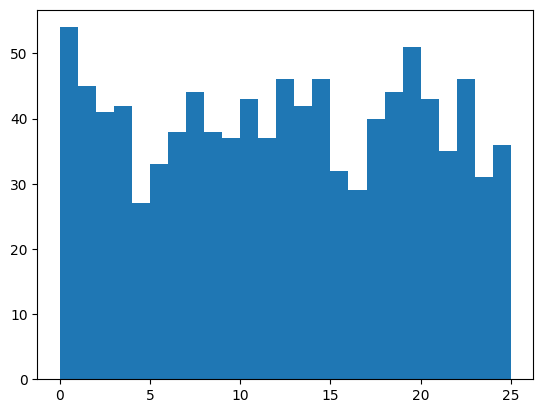

In [10]:
def plot_hist_moves(state: Nim) -> Nimply:
    list = []
    for i in range(1000):
        _, num = sample_random_move(state=state)
        list.append(num)

    plt.hist(list, bins=state.n_possible_moves(), range=(0,state.n_possible_moves())) 
    plt.show()

plot_hist_moves(nim)
# STD makes sense between 2 and 6

## Comparison between our solution and the ones provided

#### Oversimplified match

In [11]:
logging.getLogger().setLevel(logging.INFO)

strategy = (our_strategy, gabriele)

nim = Nim(6)
logging.info(f"init : {nim}")
player = 0
while nim:
    ply = strategy[player](nim)
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply)
    logging.info(f"status: {nim}")
    player = 1 - player
logging.info(f"status: Player {player} won!")

INFO:root:init : <1 3 5 7 9 11>
INFO:root:ply: player 0 plays Nimply(row=2, num_objects=3)
INFO:root:status: <1 3 2 7 9 11>
INFO:root:ply: player 1 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 3 2 7 9 11>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=2)
INFO:root:status: <0 1 2 7 9 11>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=1)
INFO:root:status: <0 0 2 7 9 11>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=7)
INFO:root:status: <0 0 2 0 9 11>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=2)
INFO:root:status: <0 0 0 0 9 11>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=9)
INFO:root:status: <0 0 0 0 0 11>
INFO:root:ply: player 1 plays Nimply(row=5, num_objects=11)
INFO:root:status: <0 0 0 0 0 0>
INFO:root:status: Player 0 won!


### Our Solution vs. Pure Random

In [16]:
def evaluate(strategy1, strategy2):
    """evaluate put a first strategy versus a second one for a certain number of times, the results is the ratio 
    between the won matches and the total number of played matches"""
    players = (strategy1, strategy2)
    won = 0

    for _ in tqdm(range(NUM_MATCHES)):
        nim = Nim(NIM_SIZE)
        player = random.randint(0,1) # make a random start
        while nim:
            ply = players[player](nim)
            nim.nimming(ply)
            player = 1 - player
        if player == 0:
            won += 1
    return round(won / NUM_MATCHES, 2)

ev_optimalvsexpert = evaluate(our_strategy, pure_random)
print(f"Our Solution vs Opponent => {ev_optimalvsexpert}")

100%|██████████| 1000/1000 [00:31<00:00, 31.72it/s]

Our Solution vs Opponent => 0.93


### Our Solution vs. Gabriele's Solution

In [13]:
def evaluate(strategy1, strategy2):
    """evaluate put a first strategy versus a second one for a certain number of times, the results is the ratio 
    between the won matches and the total number of played matches"""
    players = (strategy1, strategy2)
    won = 0

    for _ in tqdm(range(NUM_MATCHES)):
        nim = Nim(NIM_SIZE)
        player = random.randint(0,1) # make a random start
        while nim:
            ply = players[player](nim)
            nim.nimming(ply)
            player = 1 - player
        if player == 0:
            won += 1
    return round(won / NUM_MATCHES, 2)

ev_optimalvsexpert = evaluate(our_strategy, gabriele)
print(f"Our Solution vs Opponent => {ev_optimalvsexpert}")

100%|██████████| 1000/1000 [00:25<00:00, 39.59it/s]

Our Solution vs Opponent => 0.95


# New (possible) solution

In [45]:
def moves_ratio(nim: Nim) -> float:
    """
    Compute a value [0, 1] to estimate the phase of the match computing the ratio between possible moves and total moves.
    """
    # total possible moves
    possible_moves = sum([1 for _, c in enumerate(nim.rows) for _ in range(1, min(c + 1, len(nim.rows)))])
    initial_nim = Nim(len(nim.rows))
    # total moves in the start game
    total_moves = sum([1 for _, c in enumerate(initial_nim.rows) for _ in range(1, min(c + 1, len(initial_nim.rows)))])

    return possible_moves / total_moves

In [46]:
def lowest_available(state: Nim) -> Nimply:
    """Pick the lowest available move in a sequential manner."""
    for row, count in enumerate(state.rows):
        if count > 0:
            return Nimply(row, 1)
    # If all rows are empty, play a random move
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*random.choice(possible_moves))

def mirror_move(state: Nim) -> Nimply:
    """Mirror the opponent's last move."""
    if state.last_move is not None:
        row, count = state.last_move
        max_count = state.rows[row]
        mirrored_count = max_count - count + 1
        return Nimply(row, mirrored_count)
    else:
        # If it's the first move, play randomly
        possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
        return Nimply(*random.choice(possible_moves))
    
def greedy_move(state: Nim) -> Nimply:
    """Pick the move that minimizes the number of sticks in the heap"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*min(possible_moves, key=lambda m: sum(state.rows) - m[1]))

In [85]:
STRATEGIES = [lowest_available, greedy_move, optimal]
mutation_rate: float = (0.01, 0.1)

class Individual:
    n_strategy: int
    phase_thresholds: list[float]
    strategy_probs: list[list[float]]

    def __init__(self, n_strategy: int = None, strategy_probs = None, phase_thresholds = None) -> None:
        if n_strategy is None:
            n_strategy = len(STRATEGIES)
        if phase_thresholds is None:
            phase_thresholds = sorted([random.random(), random.random()])
        else:
            phase_thresholds = sorted([max(0, phase_thresholds[0]), min(1, phase_thresholds[1])])
        if strategy_probs is None:
            strategy_probs = np.random.rand(len(phase_thresholds) + 1, n_strategy)
        # n possible strategies
        self.n_strategy = n_strategy
        # threshold for each phase: in explain in which phase I am I select a different array of probabilities for the strategies
        self.phase_thresholds = phase_thresholds
        # probability for each strategy in each phase
        self.strategy_probs = strategy_probs
        
    def mutate(ind):
        global mutation_rate
        ind = deepcopy(ind)
        phase_thresholds = np.random.normal(ind.phase_thresholds, mutation_rate[0]).tolist()
        strategy_probs = np.random.normal(ind.strategy_probs, mutation_rate[1]).tolist()
        return Individual(strategy_probs = strategy_probs, phase_thresholds = phase_thresholds, n_strategy = ind.n_strategy)

    def __call__(self, state: Nim) -> Nimply:
        # compute the phase ratio: it is a value between 0 and 1 that explain in which phase I am
        phase_ratio = moves_ratio(state)
        # phase index: 0 = start, 1 = mid, 2 = end
        phase_index = (
            0
            if phase_ratio < self.phase_thresholds[0]
            else (1 if self.phase_thresholds[0] <= phase_ratio <= self.phase_thresholds[1] else 2)
        )
        # select probs strategy based on phase
        probs = self.strategy_probs[phase_index]
        # select the most probable strategy based on probs
        strategy = np.random.choice(STRATEGIES, p = softmax(probs))
        return strategy(state)

In [86]:
def match(nim: Nim, strategy) -> int:
    player = 0
    while nim:
        ply = strategy[player](nim)
        nim.nimming(ply)
        player = 1 - player
    return player

In [87]:
OPPONENT = pure_random
N_MATCHES = 100

def evaluate_games(player_strategy, n: int = N_MATCHES, opponent=OPPONENT) -> float: 
    wins = 0
    for _ in range(n):
        random_size = random.randint(4, 10)
        nim = Nim(random_size)
        wins += 1 if match(nim, (player_strategy, opponent)) == 0 else 0
    return wins / n

In [24]:
LAMBDA = 20

def evolutionary_algorithm():
    parent = Individual()
    parent_result = evaluate_games(parent)
    mutation_rate: float = (0.01, 0.1)

    pbar = tqdm(range(0, 10_000 // LAMBDA))
    for i in pbar:
        pbar.set_description(f"Parent Win-rate: {parent_result:.2%}")
        # generate offspring
        offspring = [parent.mutate() for _ in range(LAMBDA)]
        # evaluate offspring
        results = [evaluate_games(i) for i in offspring]
        # compute mutation rate: if you won more than 1/5 of the matches, increase the mutation rate, otherwise decrease it
        incr_rate = np.sum([res > parent_result for res in results]) / LAMBDA
        if incr_rate > 1 / 5:
            mutation_rate = (mutation_rate[0] * 1.1, mutation_rate[1] * 1.1)
        elif incr_rate < 1 / 5:
            mutation_rate = (mutation_rate[0] / 1.1, mutation_rate[1] / 1.1)
        # select the best offspring
        solution_ind = np.argmax(results)
        if parent_result < results[solution_ind]:
            parent = offspring[solution_ind]
            parent_result = results[solution_ind]
        # stop if the parent won more than 95% of the matches
        if parent_result >= 0.95:
            break
    return mutation_rate, parent

In [25]:
mutation_rate, parent = evolutionary_algorithm()

NameError: name 'evalutionary_algorithm' is not defined

In [89]:
mutation_rate

(2.4346850623387736e-23, 2.4346850623387733e-22)

In [90]:
parent.phase_thresholds

[0.23608452353469223, 0.8357322107956037]

In [91]:
parent.strategy_probs

[[0.30982258268170204, 0.7092627673148878, 0.9588312231951887],
 [0.7747804567219914, 0.14707364858695096, 0.24057670529930322],
 [0.49971841001458556, 0.009056858779584336, 0.32038696871549616]]

In [98]:
evaluate_games(parent, 100, pure_random)

0.38

In [26]:
evaluate_games(parent, 100, gabriele)

NameError: name 'evaluate_games' is not defined

In [97]:
evaluate_games(parent, 100, optimal)

0.29

In [ ]:
STRATEGIES = [lowest_available, greedy_move, expert_system]
mutation_rate, parent = evolutionary_algorithm()

In [ ]:
mutation_rate

In [ ]:
parent.phase_thresholds

[0.23608452353469223, 0.8357322107956037]

In [ ]:
parent.strategy_probs

[[0.30982258268170204, 0.7092627673148878, 0.9588312231951887],
 [0.7747804567219914, 0.14707364858695096, 0.24057670529930322],
 [0.49971841001458556, 0.009056858779584336, 0.32038696871549616]]

In [ ]:
evaluate_games(parent, 100, pure_random)

0.38

In [ ]:
evaluate_games(parent, 100, gabriele)

In [ ]:
evaluate_games(parent, 100, optimal)